In [1]:
%matplotlib inline
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scanpy as sc

In [77]:
# WT Scrublet

In [78]:
# 1. Load counts matrix and gene list
counts_matrix = scipy.io.mmread("D:/ZGY/MSO/WT/filtered_feature_bc_matrix/matrix.mtx").T.tocsc()
genes = np.array(scr.load_genes("D:/ZGY/MSO/WT/filtered_feature_bc_matrix/features.tsv", delimiter='\t', column=1))
print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
print('Number of genes in gene list: {}'.format(len(genes)))

Counts matrix shape: 1991 rows, 32297 columns
Number of genes in gene list: 32297


In [79]:
# 2. Initialize Scrublet object
scrub = scr.Scrublet(counts_matrix=counts_matrix, sim_doublet_ratio=2.0, n_neighbors=None, expected_doublet_rate=0.06)
# sim_doublet_ratio: the number of doublets to simulate, relative to the number of observed transcriptomes. This should be high enough that all doublet states are well-represented by simulated doublets. Setting it too high is computationally expensive. The default value is 2, though values as low as 0.5 give very similar results for the datasets that have been tested.
# n_neighbors: Number of neighbors used to construct the KNN classifier of observed transcriptomes and simulated doublets. The default value None will use round(0.5*sqrt(n_cells)) and works well.
# expected_doublet_rate: the expected fraction of transcriptomes that are doublets, typically 0.05-0.1. Results are not particularly sensitive to this parameter.

In [80]:
# 3. Run the default pipeline, which includes: Doublet simulation, Normalization, gene filtering, rescaling, PCA, Doublet score calculation, Doublet score threshold detection and doublet calling
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85, n_prin_comps=30)
# scrub_doublets() automatically identify the threshold of doublet score

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 1.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 43.1%
Elapsed time: 1.4 seconds


(<Figure size 576x216 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

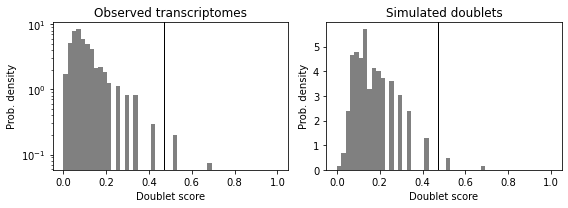

In [81]:
# 4. Plot doublet score histograms
# The simulated doublet histogram is typically bimodal.
# The left mode corresponds to "embedded" doublets generated by two cells with similar gene expression.
# The right mode corresponds to "neotypic" doublets, which are generated by cells with distinct gene expression (e.g., different cell types) and are expected to introduce more artifacts in downstream analyses.
# Scrublet can only detect neotypic doublets.
scrub.plot_histogram()

In [82]:
# 5. Get 2-D embedding to visualize the results
scrub.set_embedding('UMAP', scr.get_umap(X=scrub.manifold_obs_, n_neighbors=10, min_dist=0.3))

(<Figure size 576x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Predicted doublets'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <AxesSubplot:title={'center':'Doublet score'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

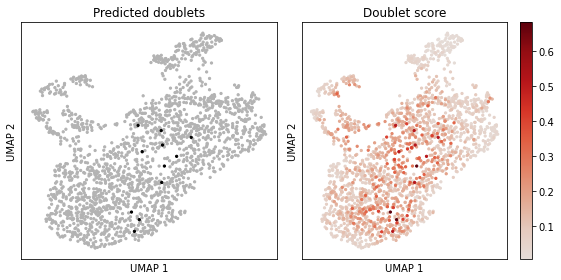

In [83]:
# 6. Plot doublet predictions on 2-D embedding
scrub.plot_embedding('UMAP', order_points=True)

In [84]:
# 7. Export Scrublet results
barcodes = pd.read_csv('D:/ZGY/MSO/WT/filtered_feature_bc_matrix/barcodes.tsv', delimiter='\t', header=None)
result = pd.DataFrame([barcodes.iloc[:,0], doublet_scores, predicted_doublets], index=["barcode", "doublet_scores","predicted_doublets"]).T
result.to_csv("D:/ZGY/MSO/WT/Scrublet_results.csv")

In [85]:
# save as h5ad after Scrublet

In [86]:
adata = sc.read_10x_mtx(path='D:/ZGY/MSO/WT/filtered_feature_bc_matrix/', var_names='gene_symbols', cache=True)

In [87]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 1991 × 32285
    var: 'gene_ids', 'feature_types'

In [88]:
Cells=pd.read_csv('D:/ZGY/MSO/WT/Scrublet_results.csv', index_col='barcode')
Cells

,Unnamed: 0,doublet_scores,predicted_doublets
barcode,,,
AAACCCAAGACTACCT-1,0,0.030928,False
AAACCCACAGCGGTCT-1,1,0.408805,False
AAACCCAGTTTCCCAC-1,2,0.076048,False
AAACGAAAGCTCAGAG-1,3,0.087379,False
AAACGAACACCTGATA-1,4,0.101338,False
...,...,...,...
TTTGATCTCTACGCGG-1,1986,0.118962,False
TTTGGAGAGCGAGAAA-1,1987,0.030928,False
TTTGGTTAGCCATGCC-1,1988,0.052037,False


In [89]:
adata.obs['predicted_doublets']=Cells['predicted_doublets']

In [90]:
WT=adata[adata.obs['predicted_doublets']==False]    # slice adata based on bool
WT

View of AnnData object with n_obs × n_vars = 1980 × 32285
    obs: 'predicted_doublets'
    var: 'gene_ids', 'feature_types'

In [91]:
WT.write('D:/ZGY/MSO/WT/WT_raw_after_Scrublet.h5ad', compression='gzip')

C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\anndata\_core\anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical


In [47]:
# KO Scrublet

In [48]:
# 1. Load counts matrix and gene list
counts_matrix = scipy.io.mmread("D:/ZGY/MSO/KO/filtered_feature_bc_matrix/matrix.mtx").T.tocsc()
genes = np.array(scr.load_genes("D:/ZGY/MSO/KO/filtered_feature_bc_matrix/features.tsv", delimiter='\t', column=1))
print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
print('Number of genes in gene list: {}'.format(len(genes)))

Counts matrix shape: 2115 rows, 32297 columns
Number of genes in gene list: 32297


In [49]:
# 2. Initialize Scrublet object
scrub = scr.Scrublet(counts_matrix=counts_matrix, sim_doublet_ratio=2.0, n_neighbors=None, expected_doublet_rate=0.06)
# sim_doublet_ratio: the number of doublets to simulate, relative to the number of observed transcriptomes. This should be high enough that all doublet states are well-represented by simulated doublets. Setting it too high is computationally expensive. The default value is 2, though values as low as 0.5 give very similar results for the datasets that have been tested.
# n_neighbors: Number of neighbors used to construct the KNN classifier of observed transcriptomes and simulated doublets. The default value None will use round(0.5*sqrt(n_cells)) and works well.
# expected_doublet_rate: the expected fraction of transcriptomes that are doublets, typically 0.05-0.1. Results are not particularly sensitive to this parameter.

In [50]:
# 3. Run the default pipeline, which includes: Doublet simulation, Normalization, gene filtering, rescaling, PCA, Doublet score calculation, Doublet score threshold detection and doublet calling
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85, n_prin_comps=30)
# scrub_doublets() automatically identify the threshold of doublet score

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.8%
Elapsed time: 1.7 seconds


(<Figure size 576x216 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

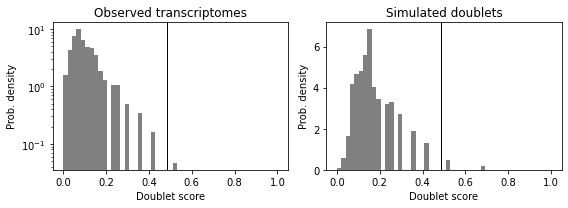

In [51]:
# 4. Plot doublet score histograms
# The simulated doublet histogram is typically bimodal.
# The left mode corresponds to "embedded" doublets generated by two cells with similar gene expression.
# The right mode corresponds to "neotypic" doublets, which are generated by cells with distinct gene expression (e.g., different cell types) and are expected to introduce more artifacts in downstream analyses.
# Scrublet can only detect neotypic doublets.
scrub.plot_histogram()

In [52]:
# 5. Get 2-D embedding to visualize the results
scrub.set_embedding('UMAP', scr.get_umap(X=scrub.manifold_obs_, n_neighbors=10, min_dist=0.3))

(<Figure size 576x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Predicted doublets'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <AxesSubplot:title={'center':'Doublet score'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

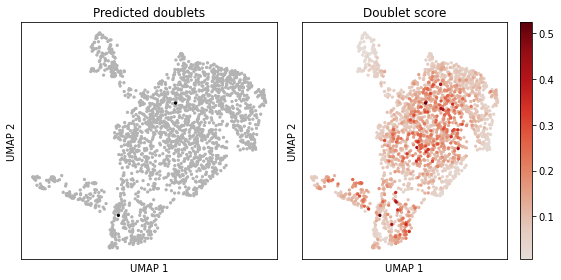

In [53]:
# 6. Plot doublet predictions on 2-D embedding
scrub.plot_embedding('UMAP', order_points=True)

In [54]:
# 7. Export Scrublet results
barcodes = pd.read_csv('D:/ZGY/MSO/KO/filtered_feature_bc_matrix/barcodes.tsv', delimiter='\t', header=None)
result = pd.DataFrame([barcodes.iloc[:,0], doublet_scores, predicted_doublets], index=["barcode", "doublet_scores","predicted_doublets"]).T
result.to_csv("D:/ZGY/MSO/KO/Scrublet_results.csv")

In [55]:
# save as h5ad after Scrublet

In [56]:
adata = sc.read_10x_mtx(path='D:/ZGY/MSO/KO/filtered_feature_bc_matrix/', var_names='gene_symbols', cache=True)

In [57]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 2115 × 32285
    var: 'gene_ids', 'feature_types'

In [58]:
Cells=pd.read_csv('D:/ZGY/MSO/KO/Scrublet_results.csv', index_col='barcode')
Cells

,Unnamed: 0,doublet_scores,predicted_doublets
barcode,,,
AAACCCACAACAAGAT-1,0,0.020359,False
AAACCCACAACTCATG-1,1,0.052346,False
AAACCCACATGTGCTA-1,2,0.106464,False
AAACCCAGTTAACCTG-1,3,0.162956,False
AAACGAAAGACAACTA-1,4,0.092045,False
...,...,...,...
TTTGTTGAGGGATCAC-1,2110,0.037440,False
TTTGTTGCAAATACGA-1,2111,0.162956,False
TTTGTTGCATTGAAAG-1,2112,0.011527,False


In [59]:
adata.obs['predicted_doublets']=Cells['predicted_doublets']

In [60]:
KO=adata[adata.obs['predicted_doublets']==False]    # slice adata based on bool
KO

View of AnnData object with n_obs × n_vars = 2113 × 32285
    obs: 'predicted_doublets'
    var: 'gene_ids', 'feature_types'

In [61]:
KO.write('D:/ZGY/MSO/KO/KO_raw_after_Scrublet.h5ad', compression='gzip')

C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\anndata\_core\anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical


In [62]:
# KP Scrublet

In [63]:
# 1. Load counts matrix and gene list
counts_matrix = scipy.io.mmread("D:/ZGY/MSO/KP/filtered_feature_bc_matrix/matrix.mtx").T.tocsc()
genes = np.array(scr.load_genes("D:/ZGY/MSO/KP/filtered_feature_bc_matrix/features.tsv", delimiter='\t', column=1))
print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
print('Number of genes in gene list: {}'.format(len(genes)))

Counts matrix shape: 1939 rows, 32297 columns
Number of genes in gene list: 32297


In [64]:
# 2. Initialize Scrublet object
scrub = scr.Scrublet(counts_matrix=counts_matrix, sim_doublet_ratio=2.0, n_neighbors=None, expected_doublet_rate=0.06)
# sim_doublet_ratio: the number of doublets to simulate, relative to the number of observed transcriptomes. This should be high enough that all doublet states are well-represented by simulated doublets. Setting it too high is computationally expensive. The default value is 2, though values as low as 0.5 give very similar results for the datasets that have been tested.
# n_neighbors: Number of neighbors used to construct the KNN classifier of observed transcriptomes and simulated doublets. The default value None will use round(0.5*sqrt(n_cells)) and works well.
# expected_doublet_rate: the expected fraction of transcriptomes that are doublets, typically 0.05-0.1. Results are not particularly sensitive to this parameter.

In [65]:
# 3. Run the default pipeline, which includes: Doublet simulation, Normalization, gene filtering, rescaling, PCA, Doublet score calculation, Doublet score threshold detection and doublet calling
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85, n_prin_comps=30)
# scrub_doublets() automatically identify the threshold of doublet score

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 1.9%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 18.9%
Elapsed time: 1.4 seconds


(<Figure size 576x216 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

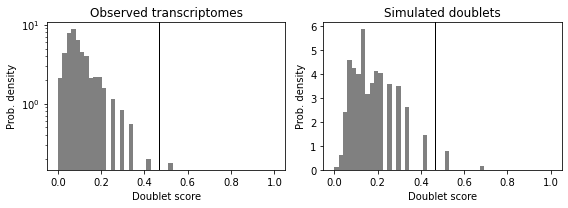

In [66]:
# 4. Plot doublet score histograms
# The simulated doublet histogram is typically bimodal.
# The left mode corresponds to "embedded" doublets generated by two cells with similar gene expression.
# The right mode corresponds to "neotypic" doublets, which are generated by cells with distinct gene expression (e.g., different cell types) and are expected to introduce more artifacts in downstream analyses.
# Scrublet can only detect neotypic doublets.
scrub.plot_histogram()

In [67]:
# 5. Get 2-D embedding to visualize the results
scrub.set_embedding('UMAP', scr.get_umap(X=scrub.manifold_obs_, n_neighbors=10, min_dist=0.3))

(<Figure size 576x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Predicted doublets'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <AxesSubplot:title={'center':'Doublet score'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

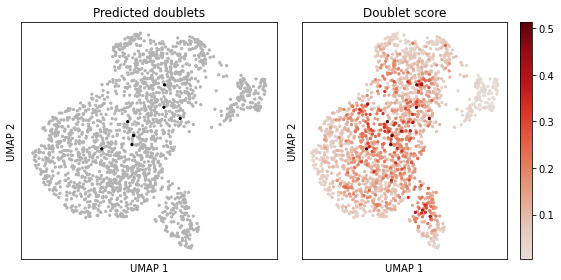

In [68]:
# 6. Plot doublet predictions on 2-D embedding
scrub.plot_embedding('UMAP', order_points=True)

In [69]:
# 7. Export Scrublet results
barcodes = pd.read_csv('D:/ZGY/MSO/KP/filtered_feature_bc_matrix/barcodes.tsv', delimiter='\t', header=None)
result = pd.DataFrame([barcodes.iloc[:,0], doublet_scores, predicted_doublets], index=["barcode", "doublet_scores","predicted_doublets"]).T
result.to_csv("D:/ZGY/MSO/KP/Scrublet_results.csv")

In [70]:
# save as h5ad after Scrublet

In [71]:
adata = sc.read_10x_mtx(path='D:/ZGY/MSO/KP/filtered_feature_bc_matrix/', var_names='gene_symbols', cache=True)

In [72]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 1939 × 32285
    var: 'gene_ids', 'feature_types'

In [73]:
Cells=pd.read_csv('D:/ZGY/MSO/KP/Scrublet_results.csv', index_col='barcode')
Cells

,Unnamed: 0,doublet_scores,predicted_doublets
barcode,,,
AAACGAACACCGCTAG-1,0,0.055276,False
AAACGAATCTCAAAGC-1,1,0.217598,False
AAACGAATCTCTGCCA-1,2,0.081433,False
AAACGCTAGGTGCTAG-1,3,0.087379,False
AAACGCTCAGAGCGTA-1,4,0.052037,False
...,...,...,...
TTTGGTTAGCCTTTCC-1,1934,0.058772,False
TTTGGTTAGGTACCTT-1,1935,0.141909,False
TTTGGTTCAAAGCTAA-1,1936,0.038855,False


In [74]:
adata.obs['predicted_doublets']=Cells['predicted_doublets']

In [75]:
KP=adata[adata.obs['predicted_doublets']==False]    # slice adata based on bool
KP

View of AnnData object with n_obs × n_vars = 1932 × 32285
    obs: 'predicted_doublets'
    var: 'gene_ids', 'feature_types'

In [76]:
KP.write('D:/ZGY/MSO/KP/KP_raw_after_Scrublet.h5ad', compression='gzip')

C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\anndata\_core\anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical


In [2]:
# CKP Scrublet

In [3]:
# 1. Load counts matrix and gene list
counts_matrix = scipy.io.mmread("D:/ZGY/MSO/CKP/filtered_feature_bc_matrix/matrix.mtx").T.tocsc()
genes = np.array(scr.load_genes("D:/ZGY/MSO/CKP/filtered_feature_bc_matrix/features.tsv", delimiter='\t', column=1))
print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
print('Number of genes in gene list: {}'.format(len(genes)))

Counts matrix shape: 1822 rows, 32297 columns
Number of genes in gene list: 32297


In [4]:
# 2. Initialize Scrublet object
scrub = scr.Scrublet(counts_matrix=counts_matrix, sim_doublet_ratio=2.0, n_neighbors=None, expected_doublet_rate=0.06)
# sim_doublet_ratio: the number of doublets to simulate, relative to the number of observed transcriptomes. This should be high enough that all doublet states are well-represented by simulated doublets. Setting it too high is computationally expensive. The default value is 2, though values as low as 0.5 give very similar results for the datasets that have been tested.
# n_neighbors: Number of neighbors used to construct the KNN classifier of observed transcriptomes and simulated doublets. The default value None will use round(0.5*sqrt(n_cells)) and works well.
# expected_doublet_rate: the expected fraction of transcriptomes that are doublets, typically 0.05-0.1. Results are not particularly sensitive to this parameter.

In [5]:
# 3. Run the default pipeline, which includes: Doublet simulation, Normalization, gene filtering, rescaling, PCA, Doublet score calculation, Doublet score threshold detection and doublet calling
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85, n_prin_comps=30)
# scrub_doublets() automatically identify the threshold of doublet score

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 2.7%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 14.4%
Elapsed time: 1.9 seconds


(<Figure size 576x216 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

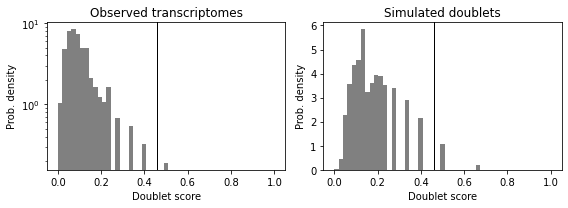

In [6]:
# 4. Plot doublet score histograms
# The simulated doublet histogram is typically bimodal.
# The left mode corresponds to "embedded" doublets generated by two cells with similar gene expression.
# The right mode corresponds to "neotypic" doublets, which are generated by cells with distinct gene expression (e.g., different cell types) and are expected to introduce more artifacts in downstream analyses.
# Scrublet can only detect neotypic doublets.
scrub.plot_histogram()

In [7]:
# 5. Get 2-D embedding to visualize the results
scrub.set_embedding('UMAP', scr.get_umap(X=scrub.manifold_obs_, n_neighbors=10, min_dist=0.3))

(<Figure size 576x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Predicted doublets'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <AxesSubplot:title={'center':'Doublet score'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

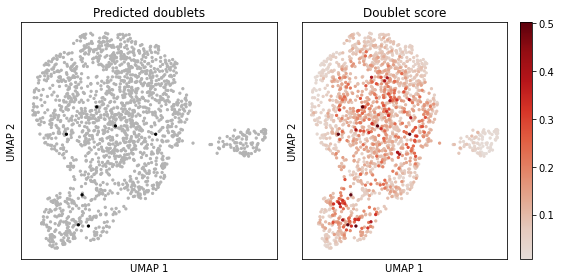

In [8]:
# 6. Plot doublet predictions on 2-D embedding
scrub.plot_embedding('UMAP', order_points=True)

In [9]:
# 7. Export Scrublet results
barcodes = pd.read_csv('D:/ZGY/MSO/CKP/filtered_feature_bc_matrix/barcodes.tsv', delimiter='\t', header=None)
result = pd.DataFrame([barcodes.iloc[:,0], doublet_scores, predicted_doublets], index=["barcode", "doublet_scores","predicted_doublets"]).T
result.to_csv("D:/ZGY/MSO/CKP/Scrublet_results.csv")

In [10]:
# save as h5ad after Scrublet

In [11]:
adata = sc.read_10x_mtx(path='D:/ZGY/MSO/CKP/filtered_feature_bc_matrix/', var_names='gene_symbols', cache=True)

In [12]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 1822 × 32285
    var: 'gene_ids', 'feature_types'

In [13]:
Cells=pd.read_csv('D:/ZGY/MSO/CKP/Scrublet_results.csv', index_col='barcode')
Cells

,Unnamed: 0,doublet_scores,predicted_doublets
barcode,,,
AAACCCAAGTGTTCCA-1,0,0.062678,False
AAACGAACACGTAGTT-1,1,0.055070,False
AAACGAAGTCTATGAC-1,2,0.104152,False
AAACGCTTCAGGTAAA-1,3,0.209135,False
AAAGAACAGAAATGGG-1,4,0.058716,False
...,...,...,...
TTTGGTTCATCCAACA-1,1817,0.238866,False
TTTGGTTTCCTCAGGG-1,1818,0.185265,False
TTTGTTGAGAGTTGTA-1,1819,0.096154,False


In [14]:
adata.obs['predicted_doublets']=Cells['predicted_doublets']

In [15]:
CKP=adata[adata.obs['predicted_doublets']==False]    # slice adata based on bool
CKP

View of AnnData object with n_obs × n_vars = 1815 × 32285
    obs: 'predicted_doublets'
    var: 'gene_ids', 'feature_types'

In [16]:
CKP.write('D:/ZGY/MSO/CKP/CKP_raw_after_Scrublet.h5ad', compression='gzip')

C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\anndata\_core\anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical


In [32]:
# EKP Scrublet

In [33]:
# 1. Load counts matrix and gene list
counts_matrix = scipy.io.mmread("D:/ZGY/MSO/EKP/filtered_feature_bc_matrix/matrix.mtx").T.tocsc()
genes = np.array(scr.load_genes("D:/ZGY/MSO/EKP/filtered_feature_bc_matrix/features.tsv", delimiter='\t', column=1))
print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
print('Number of genes in gene list: {}'.format(len(genes)))

Counts matrix shape: 2627 rows, 32297 columns
Number of genes in gene list: 32297


In [34]:
# 2. Initialize Scrublet object
scrub = scr.Scrublet(counts_matrix=counts_matrix, sim_doublet_ratio=2.0, n_neighbors=None, expected_doublet_rate=0.06)
# sim_doublet_ratio: the number of doublets to simulate, relative to the number of observed transcriptomes. This should be high enough that all doublet states are well-represented by simulated doublets. Setting it too high is computationally expensive. The default value is 2, though values as low as 0.5 give very similar results for the datasets that have been tested.
# n_neighbors: Number of neighbors used to construct the KNN classifier of observed transcriptomes and simulated doublets. The default value None will use round(0.5*sqrt(n_cells)) and works well.
# expected_doublet_rate: the expected fraction of transcriptomes that are doublets, typically 0.05-0.1. Results are not particularly sensitive to this parameter.

In [35]:
# 3. Run the default pipeline, which includes: Doublet simulation, Normalization, gene filtering, rescaling, PCA, Doublet score calculation, Doublet score threshold detection and doublet calling
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85, n_prin_comps=30)
# scrub_doublets() automatically identify the threshold of doublet score

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 19.4%
Elapsed time: 2.6 seconds


(<Figure size 576x216 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

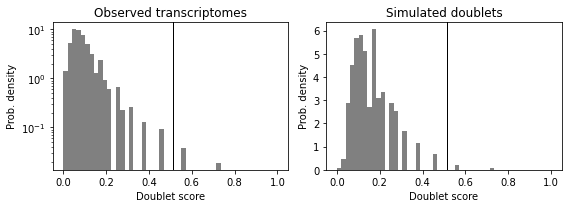

In [36]:
# 4. Plot doublet score histograms
# The simulated doublet histogram is typically bimodal.
# The left mode corresponds to "embedded" doublets generated by two cells with similar gene expression.
# The right mode corresponds to "neotypic" doublets, which are generated by cells with distinct gene expression (e.g., different cell types) and are expected to introduce more artifacts in downstream analyses.
# Scrublet can only detect neotypic doublets.
scrub.plot_histogram()

In [37]:
# 5. Get 2-D embedding to visualize the results
scrub.set_embedding('UMAP', scr.get_umap(X=scrub.manifold_obs_, n_neighbors=10, min_dist=0.3))

(<Figure size 576x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Predicted doublets'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <AxesSubplot:title={'center':'Doublet score'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

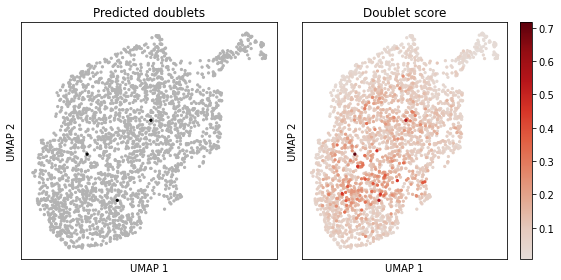

In [38]:
# 6. Plot doublet predictions on 2-D embedding
scrub.plot_embedding('UMAP', order_points=True)

In [39]:
# 7. Export Scrublet results
barcodes = pd.read_csv('D:/ZGY/MSO/EKP/filtered_feature_bc_matrix/barcodes.tsv', delimiter='\t', header=None)
result = pd.DataFrame([barcodes.iloc[:,0], doublet_scores, predicted_doublets], index=["barcode", "doublet_scores","predicted_doublets"]).T
result.to_csv("D:/ZGY/MSO/EKP/Scrublet_results.csv")

In [40]:
# save as h5ad after Scrublet

In [41]:
adata = sc.read_10x_mtx(path='D:/ZGY/MSO/EKP/filtered_feature_bc_matrix/', var_names='gene_symbols', cache=True)

In [42]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 2627 × 32285
    var: 'gene_ids', 'feature_types'

In [43]:
Cells=pd.read_csv('D:/ZGY/MSO/EKP/Scrublet_results.csv', index_col='barcode')
Cells

,Unnamed: 0,doublet_scores,predicted_doublets
barcode,,,
AAACCCAAGGATATAC-1,0,0.048024,False
AAACCCACAAGCTGTT-1,1,0.069307,False
AAACCCACAATACGAA-1,2,0.039416,False
AAACGAAAGTGCCTCG-1,3,0.153153,False
AAACGAACACTTCTCG-1,4,0.045685,False
...,...,...,...
TTTGGTTGTAGAGATT-1,2622,0.055954,False
TTTGGTTGTTGCTGAT-1,2623,0.201133,False
TTTGGTTTCTCCCTAG-1,2624,0.105764,False


In [44]:
adata.obs['predicted_doublets']=Cells['predicted_doublets']

In [45]:
EKP=adata[adata.obs['predicted_doublets']==False]    # slice adata based on bool
EKP

View of AnnData object with n_obs × n_vars = 2624 × 32285
    obs: 'predicted_doublets'
    var: 'gene_ids', 'feature_types'

In [46]:
EKP.write('D:/ZGY/MSO/EKP/EKP_raw_after_Scrublet.h5ad', compression='gzip')

C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\anndata\_core\anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical


In [17]:
# CP Scrublet

In [18]:
# 1. Load counts matrix and gene list
counts_matrix = scipy.io.mmread("D:/ZGY/MSO/CP/filtered_feature_bc_matrix/matrix.mtx").T.tocsc()
genes = np.array(scr.load_genes("D:/ZGY/MSO/CP/filtered_feature_bc_matrix/features.tsv", delimiter='\t', column=1))
print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
print('Number of genes in gene list: {}'.format(len(genes)))

Counts matrix shape: 2467 rows, 32297 columns
Number of genes in gene list: 32297


In [19]:
# 2. Initialize Scrublet object
scrub = scr.Scrublet(counts_matrix=counts_matrix, sim_doublet_ratio=2.0, n_neighbors=None, expected_doublet_rate=0.06)
# sim_doublet_ratio: the number of doublets to simulate, relative to the number of observed transcriptomes. This should be high enough that all doublet states are well-represented by simulated doublets. Setting it too high is computationally expensive. The default value is 2, though values as low as 0.5 give very similar results for the datasets that have been tested.
# n_neighbors: Number of neighbors used to construct the KNN classifier of observed transcriptomes and simulated doublets. The default value None will use round(0.5*sqrt(n_cells)) and works well.
# expected_doublet_rate: the expected fraction of transcriptomes that are doublets, typically 0.05-0.1. Results are not particularly sensitive to this parameter.

In [20]:
# 3. Run the default pipeline, which includes: Doublet simulation, Normalization, gene filtering, rescaling, PCA, Doublet score calculation, Doublet score threshold detection and doublet calling
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85, n_prin_comps=30)
# scrub_doublets() automatically identify the threshold of doublet score

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.8%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 5.0%
Elapsed time: 2.3 seconds


(<Figure size 576x216 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

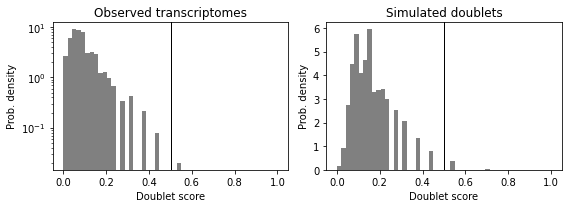

In [21]:
# 4. Plot doublet score histograms
# The simulated doublet histogram is typically bimodal.
# The left mode corresponds to "embedded" doublets generated by two cells with similar gene expression.
# The right mode corresponds to "neotypic" doublets, which are generated by cells with distinct gene expression (e.g., different cell types) and are expected to introduce more artifacts in downstream analyses.
# Scrublet can only detect neotypic doublets.
scrub.plot_histogram()

In [22]:
# 5. Get 2-D embedding to visualize the results
scrub.set_embedding('UMAP', scr.get_umap(X=scrub.manifold_obs_, n_neighbors=10, min_dist=0.3))

(<Figure size 576x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Predicted doublets'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <AxesSubplot:title={'center':'Doublet score'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

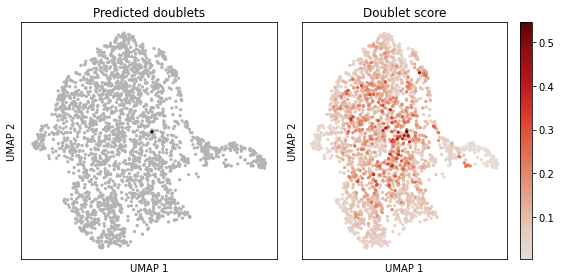

In [23]:
# 6. Plot doublet predictions on 2-D embedding
scrub.plot_embedding('UMAP', order_points=True)

In [24]:
# 7. Export Scrublet results
barcodes = pd.read_csv('D:/ZGY/MSO/CP/filtered_feature_bc_matrix/barcodes.tsv', delimiter='\t', header=None)
result = pd.DataFrame([barcodes.iloc[:,0], doublet_scores, predicted_doublets], index=["barcode", "doublet_scores","predicted_doublets"]).T
result.to_csv("D:/ZGY/MSO/CP/Scrublet_results.csv")

In [25]:
# save as h5ad after Scrublet

In [26]:
adata = sc.read_10x_mtx(path='D:/ZGY/MSO/CP/filtered_feature_bc_matrix/', var_names='gene_symbols', cache=True)

In [27]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 2467 × 32285
    var: 'gene_ids', 'feature_types'

In [28]:
Cells=pd.read_csv('D:/ZGY/MSO/CP/Scrublet_results.csv', index_col='barcode')
Cells

,Unnamed: 0,doublet_scores,predicted_doublets
barcode,,,
AAACCCAAGATAACGT-1,0,0.135785,False
AAACCCAAGGTATTGA-1,1,0.062251,False
AAACCCAAGGTCATCT-1,2,0.050174,False
AAACCCACACAATGTC-1,3,0.160714,False
AAACCCACATCATGAC-1,4,0.094703,False
...,...,...,...
TTTGGAGAGGCCACTC-1,2462,0.018917,False
TTTGGAGAGGGCCAAT-1,2463,0.055804,False
TTTGGAGCATAGCTGT-1,2464,0.052897,False


In [29]:
adata.obs['predicted_doublets']=Cells['predicted_doublets']

In [30]:
CP=adata[adata.obs['predicted_doublets']==False]    # slice adata based on bool
CP

View of AnnData object with n_obs × n_vars = 2466 × 32285
    obs: 'predicted_doublets'
    var: 'gene_ids', 'feature_types'

In [31]:
CP.write('D:/ZGY/MSO/CP/CP_raw_after_Scrublet.h5ad', compression='gzip')

C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\anndata\_core\anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
